In [7]:
"""
Path planning Sample Code with RRT with path smoothing
@author: AtsushiSakai(@Atsushi_twi)
"""

import math
import os
import random
import sys
import numpy as np
import random

from matplotlib import rc
rc('animation', html='jshtml')
import matplotlib.pyplot as plt

show_animation = True  


In [8]:
class RRT:
    """
    Class for RRT planning
    """

    class Node:
        """
        RRT Node
        """

        def __init__(self, x, y):
            self.x = x
            self.y = y
            self.path_x = []
            self.path_y = []
            self.parent = None

    def __init__(self,
                 start,
                 goal,
                 obstacle_list,
                 rand_area,
                 expand_dis=3.0,
                 path_resolution=0.5,
                 goal_sample_rate=5,
                 max_iter=500):
        """
        Setting Parameter
        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacleList:obstacle Positions [[x,y,size],...]
        randArea:Random Sampling Area [min,max]
        """
        self.start = self.Node(start[0], start[1])
        self.end = self.Node(goal[0], goal[1])
        self.min_rand = rand_area[0]
        self.max_rand = rand_area[1]
        self.expand_dis = expand_dis
        self.path_resolution = path_resolution
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.node_list = []

    def planning(self, animation=True):
        """
        rrt path planning
        animation: flag for animation on or off
        """

        self.node_list = [self.start]
        for i in range(self.max_iter):
            rnd_node = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd_node)
            nearest_node = self.node_list[nearest_ind]

            new_node = self.steer(nearest_node, rnd_node, self.expand_dis)

            if self.check_collision(new_node, self.obstacle_list):
                self.node_list.append(new_node)

            if animation and i % 5 == 0:
                self.draw_graph(rnd_node)

            if self.calc_dist_to_goal(self.node_list[-1].x,
                                      self.node_list[-1].y) <= self.expand_dis:
                final_node = self.steer(self.node_list[-1], self.end,
                                        self.expand_dis)
                if self.check_collision(final_node, self.obstacle_list):
                    return self.generate_final_course(len(self.node_list) - 1)

            if animation and i % 5:
                self.draw_graph(rnd_node)

        return None  # cannot find path

    def steer(self, from_node, to_node, extend_length=float("inf")):

        new_node = self.Node(from_node.x, from_node.y)
        d, theta = self.calc_distance_and_angle(new_node, to_node)

        new_node.path_x = [new_node.x]
        new_node.path_y = [new_node.y]

        if extend_length > d:
            extend_length = d

        n_expand = math.floor(extend_length / self.path_resolution)

        """ Interpolate line onto discrete space """
        for _ in range(n_expand):
            new_node.x += self.path_resolution * math.cos(theta)
            new_node.y += self.path_resolution * math.sin(theta)
            new_node.path_x.append(new_node.x)
            new_node.path_y.append(new_node.y)

        """ Tolerance Check? """
        d, _ = self.calc_distance_and_angle(new_node, to_node)
        if d <= self.path_resolution:
            new_node.path_x.append(to_node.x)
            new_node.path_y.append(to_node.y)
            new_node.x = to_node.x
            new_node.y = to_node.y

        new_node.parent = from_node

        return new_node

    def generate_final_course(self, goal_ind):
        path = [[self.end.x, self.end.y]]
        node = self.node_list[goal_ind]
        while node.parent is not None:
            path.append([node.x, node.y])
            node = node.parent
        path.append([node.x, node.y])

        return path

    def calc_dist_to_goal(self, x, y):
        dx = x - self.end.x
        dy = y - self.end.y
        return math.hypot(dx, dy)

    def get_random_node(self):
        if random.randint(0, 100) > self.goal_sample_rate:
            rnd = self.Node(
                random.uniform(self.min_rand, self.max_rand),
                random.uniform(self.min_rand, self.max_rand))
        else:  # goal point sampling
            rnd = self.Node(self.end.x, self.end.y)
        return rnd

    def draw_graph(self, rnd=None):
        plt.clf()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect(
            'key_release_event',
            lambda event: [exit(0) if event.key == 'escape' else None])
        if rnd is not None:
            plt.plot(rnd.x, rnd.y, "^k")
        for node in self.node_list:
            if node.parent:
                plt.plot(node.path_x, node.path_y, "-g")

        for (ox, oy, size) in self.obstacle_list:
            self.plot_circle(ox, oy, size)

        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.end.x, self.end.y, "xr")
        plt.axis("equal")
        plt.axis([-2, 15, -2, 15])
        plt.grid(True)

        plt.savefig("./images/rrt.png")

        plt.pause(0.01)

    @staticmethod
    def plot_circle(x, y, size, color="-b"):  # pragma: no cover
        deg = list(range(0, 360, 5))
        deg.append(0)
        xl = [x + size * math.cos(np.deg2rad(d)) for d in deg]
        yl = [y + size * math.sin(np.deg2rad(d)) for d in deg]
        plt.plot(xl, yl, color)

    @staticmethod
    def get_nearest_node_index(node_list, rnd_node):
        dlist = [(node.x - rnd_node.x)**2 + (node.y - rnd_node.y)**2
                 for node in node_list]
        minind = dlist.index(min(dlist))

        return minind

    @staticmethod
    def check_collision(node, obstacleList):

        if node is None:
            return False

        for (ox, oy, size) in obstacleList:
            dx_list = [ox - x for x in node.path_x]
            dy_list = [oy - y for y in node.path_y]
            d_list = [dx * dx + dy * dy for (dx, dy) in zip(dx_list, dy_list)]

            if min(d_list) <= size**2:
                return False  # collision

        return True  # safe

    @staticmethod
    def calc_distance_and_angle(from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        d = math.hypot(dx, dy)
        theta = math.atan2(dy, dx)
        return d, theta

In [9]:
class RRT_closest(RRT):
    """
    RRT except returns closest path instead of None
    """

    def __init__(self,
                 start,
                 goal,
                 obstacle_list,
                 rand_area,
                 expand_dis=3.0,
                 path_resolution=0.5,
                 goal_sample_rate=5,
                 max_iter=5,
                 obj_reached=False):
        """
        Setting Parameter
        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacleList:obstacle Positions [[x,y,size],...]
        randArea:Random Sampling Area [min,max]
        """
        self.start = self.Node(start[0], start[1])
        self.end = self.Node(goal[0], goal[1])
        self.min_rand = rand_area[0]
        self.max_rand = rand_area[1]
        self.expand_dis = expand_dis
        self.path_resolution = path_resolution
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.node_list = []
        self.obj_reached = obj_reached
    
    """ 
    Necessary function because RRT.planning() will 
    always return a path, even if not to the goal
    """
    def goal_reached(self):
        return self.obj_reached


    def planning(self, animation=True):
        """
        rrt path planning
        animation: flag for animation on or off
        """

        """ added """
        best_ind = 0
        best_node = self.start

        self.node_list = [self.start]
        for i in range(self.max_iter):
            rnd_node = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd_node)
            nearest_node = self.node_list[nearest_ind]

            new_node = self.steer(nearest_node, rnd_node, self.expand_dis)

            if self.check_collision(new_node, self.obstacle_list):
                self.node_list.append(new_node)

            if animation and i % 5 == 0:
                self.draw_graph(rnd_node)

            """ distance between new_node and goal """
            new_dist = self.calc_dist_to_goal(self.node_list[-1].x, self.node_list[-1].y)
            if  new_dist <= self.expand_dis:
                final_node = self.steer(self.node_list[-1], self.end,
                                        self.expand_dis)
                if self.check_collision(final_node, self.obstacle_list):
                    self.obj_reached = True
                    return self.generate_final_course(len(self.node_list) - 1)

            """ update best_node """
            if new_dist <= self.calc_dist_to_goal(best_node.x, best_node.y):
                best_ind = len(self.node_list) - 1
                best_node = new_node

            if animation and i % 5:
                self.draw_graph(rnd_node)

        """ generate path from best_node to start_node """
        return self.generate_course(best_ind)

    def generate_course(self, goal_ind):
        node = self.node_list[goal_ind]
        path = []
        while node.parent is not None:
            path.append([node.x, node.y])
            node = node.parent
        path.append([node.x, node.y])

        return path

In [10]:
def get_path_length(path):
    le = 0
    for i in range(len(path) - 1):
        dx = path[i + 1][0] - path[i][0]
        dy = path[i + 1][1] - path[i][1]
        d = math.sqrt(dx * dx + dy * dy)
        le += d

    return le


def get_target_point(path, targetL):
    le = 0
    ti = 0
    lastPairLen = 0
    for i in range(len(path) - 1):
        dx = path[i + 1][0] - path[i][0]
        dy = path[i + 1][1] - path[i][1]
        d = math.sqrt(dx * dx + dy * dy)
        le += d
        if le >= targetL:
            ti = i - 1
            lastPairLen = d
            break

    partRatio = (le - targetL) / lastPairLen

    x = path[ti][0] + (path[ti + 1][0] - path[ti][0]) * partRatio
    y = path[ti][1] + (path[ti + 1][1] - path[ti][1]) * partRatio

    return [x, y, ti]


def line_collision_check(first, second, obstacleList):
    # Line Equation

    x1 = first[0]
    y1 = first[1]
    x2 = second[0]
    y2 = second[1]

    try:
        a = y2 - y1
        b = -(x2 - x1)
        c = y2 * (x2 - x1) - x2 * (y2 - y1)
    except ZeroDivisionError:
        return False

    for (ox, oy, size) in obstacleList:
        d = abs(a * ox + b * oy + c) / (math.sqrt(a * a + b * b))
        if d <= size:
            return False

    return True  # OK


def path_smoothing(path, max_iter, obstacle_list):
    le = get_path_length(path)

    for i in range(max_iter):
        # Sample two points
        pickPoints = [random.uniform(0, le), random.uniform(0, le)]
        pickPoints.sort()
        first = get_target_point(path, pickPoints[0])
        second = get_target_point(path, pickPoints[1])

        if first[2] <= 0 or second[2] <= 0:
            continue

        if (second[2] + 1) > len(path):
            continue

        if second[2] == first[2]:
            continue

        # collision check
        if not line_collision_check(first, second, obstacle_list):
            continue

        # Create New path
        newPath = []
        newPath.extend(path[:first[2] + 1])
        newPath.append([first[0], first[1]])
        newPath.append([second[0], second[1]])
        newPath.extend(path[second[2] + 1:])
        path = newPath
        le = get_path_length(path)

    return path

found path!!


FileNotFoundError: ignored

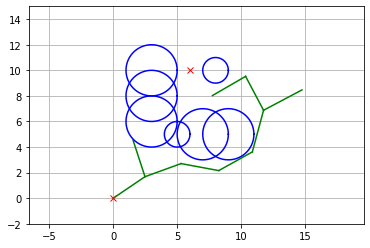

In [11]:
# No Path Smoothing

# ====Search Path with RRT====
obstacleList = [(5, 5, 1), (3, 6, 2), (3, 8, 2), (3, 10, 2), (7, 5, 2),
                (9, 5, 2), (8, 10, 1)]  # [x, y, radius]
# Set Initial parameters
rrt = RRT(
    start=[0, 0],
    goal=[6, 10],
    rand_area=[-2, 15],
    obstacle_list=obstacleList)
path = rrt.planning(animation=False)

if path is None:
    print("Cannot find path")
else:
    print("found path!!")

    # Draw final path
    if show_animation:
        rrt.draw_graph()
        plt.plot([x for (x, y) in path], [y for (x, y) in path], '-r')
        plt.grid(True)
        plt.pause(0.01)  # Need for Mac
        plt.show()


In [ ]:
# No Path Smoothing

# ====Search Path with RRT====
obstacleList = [(5, 5, 1), (3, 6, 2), (3, 8, 2), (3, 10, 2), (7, 5, 2),
                (9, 5, 2), (8, 10, 1)]  # [x, y, radius]
# Set Initial parameters
rrt = RRT_closest(
    start=[0, 0],
    goal=[6, 10],
    rand_area=[-2, 15],
    obstacle_list=obstacleList,
    max_iter=50)
path = rrt.planning(animation=True)

if path is None:
    print("Cannot find path")
else:
    print("found path!!")

    # Draw final path
    if show_animation:
        rrt.draw_graph()
        plt.plot([x for (x, y) in path], [y for (x, y) in path], '-r')
        plt.grid(True)
        plt.pause(0.01)  # Need for Mac
        plt.show()

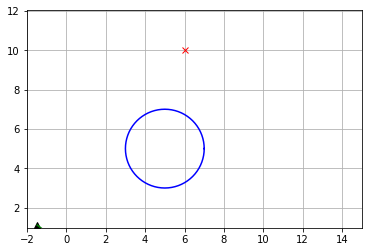

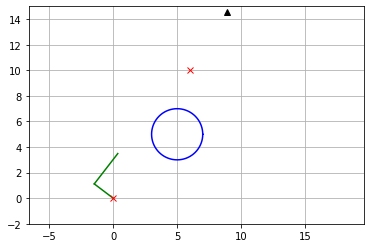

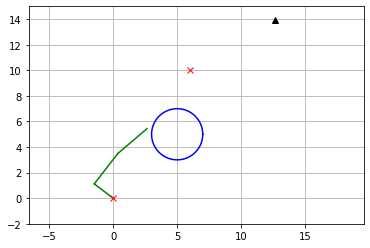

found path!!


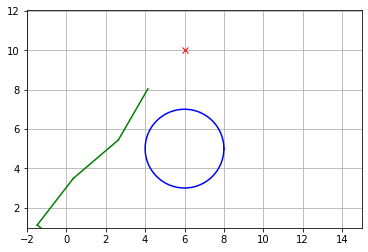

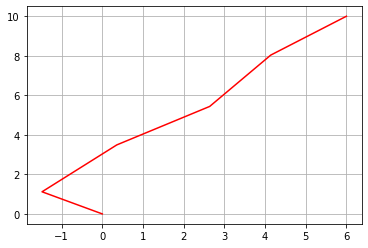

In [ ]:
curr = [0, 0]
x, y, r = 5, 5, 2
dir = 1
obstacleList = [(x, y, r)]

while (True):
    rrt = RRT_closest(
        start=curr,
        goal=[6, 10],
        rand_area=[-2, 15],
        obstacle_list=obstacleList,
        max_iter=5)
    path = rrt.planning(animation=True)

    x += dir * 1
    if x >= 10:dir = -1
    if x <= 0:dir = 1
    obstacleList[0] = (x, y, r)

    if rrt.goal_reached():
        print("found path!!")
        break
    else:
        curr = [path[0][0], path[0][1]]
        del rrt

rrt.draw_graph()
plt.plot([x for (x, y) in path], [y for (x, y) in path], '-r')
plt.grid(True)
plt.pause(0.01)  # Need for Mac
plt.show()

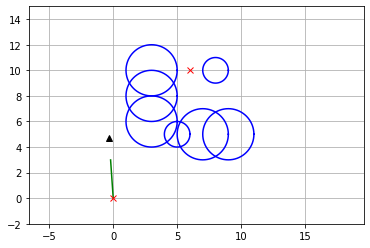

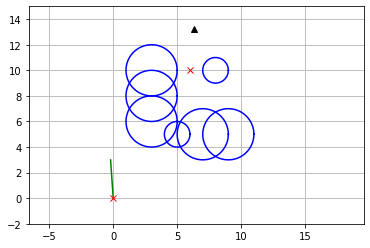

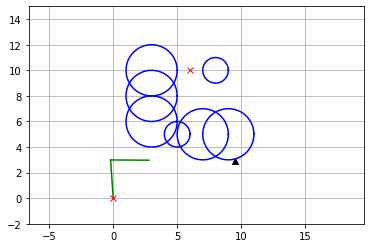

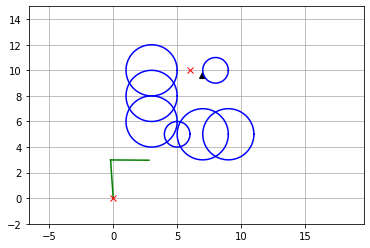

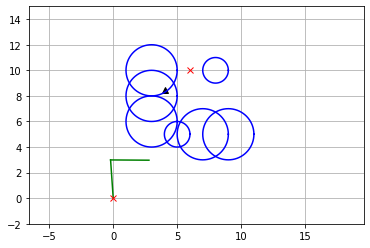

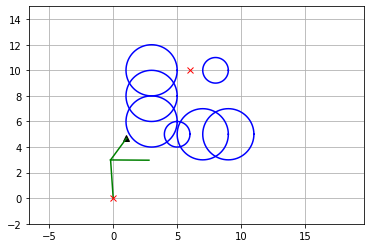

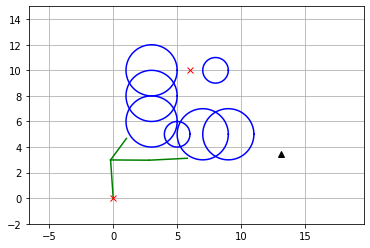

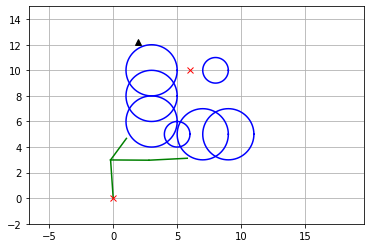

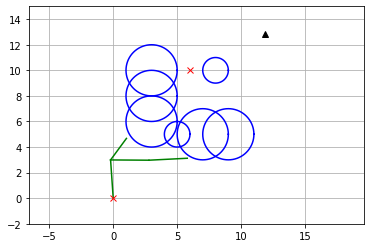

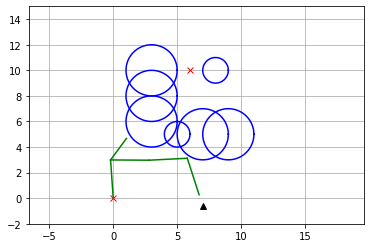

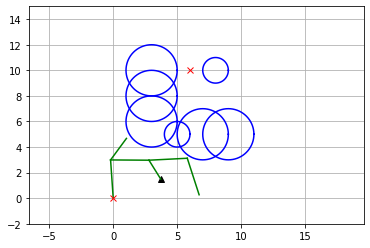

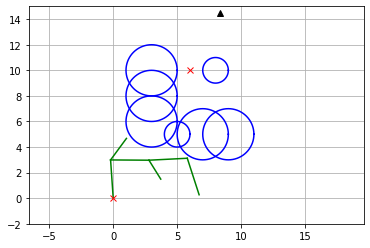

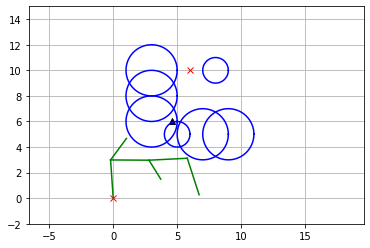

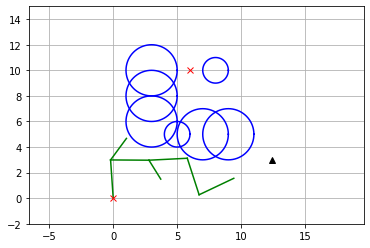

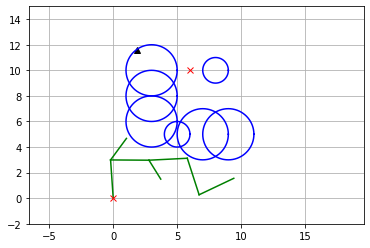

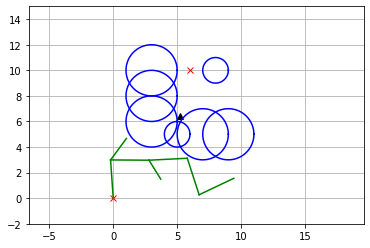

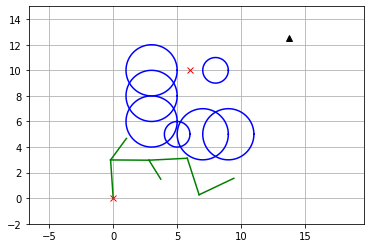

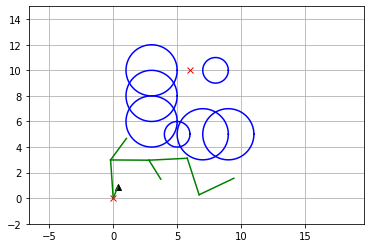

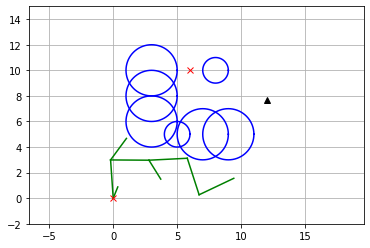

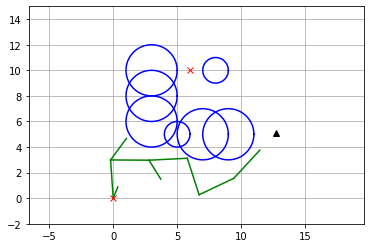

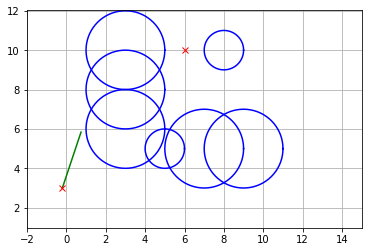

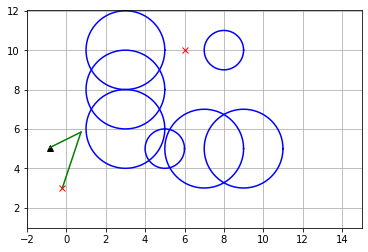

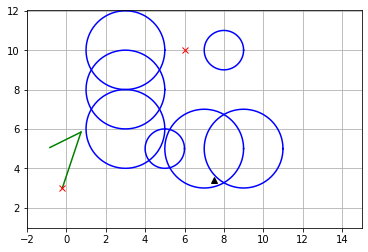

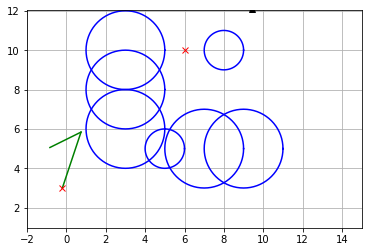

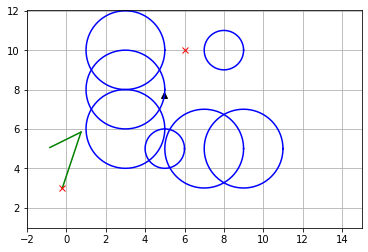

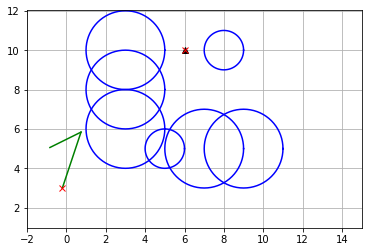

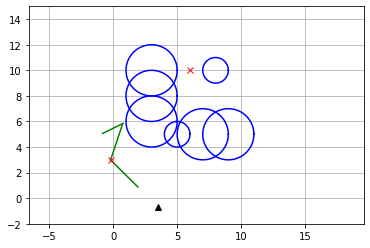

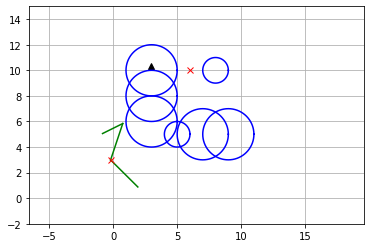

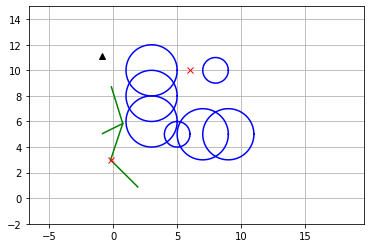

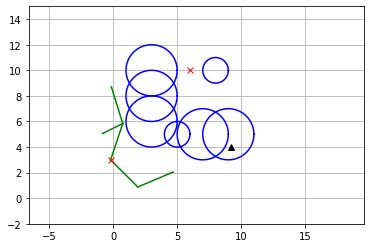

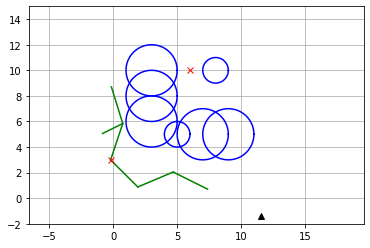

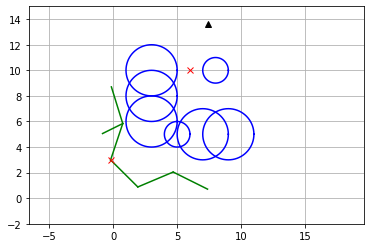

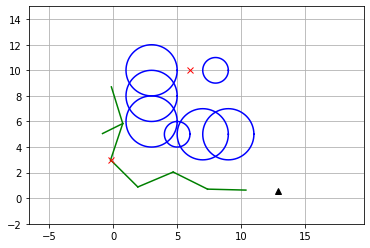

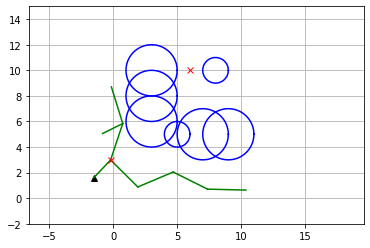

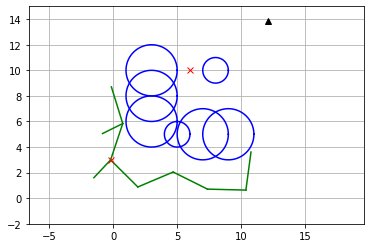

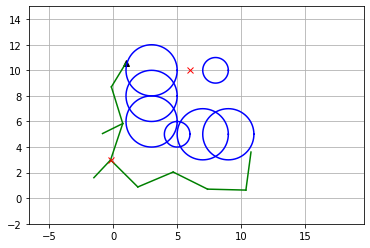

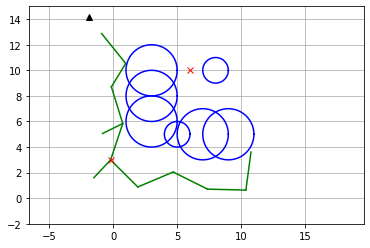

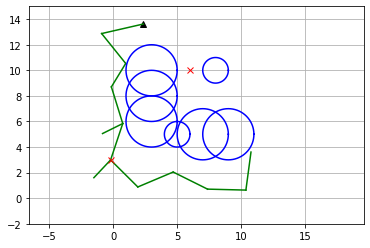

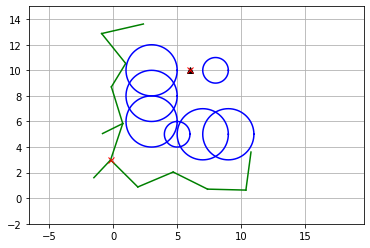

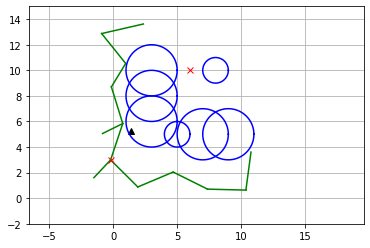

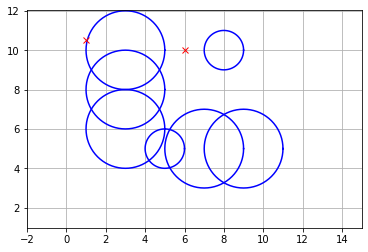

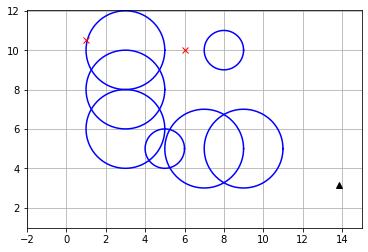

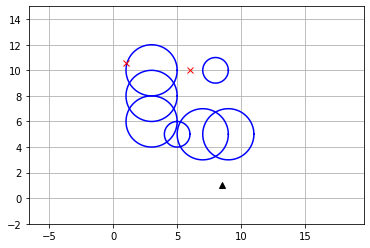

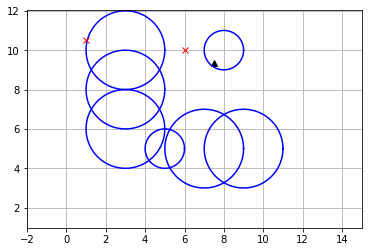

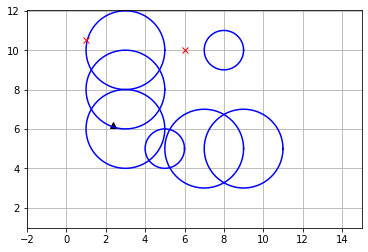

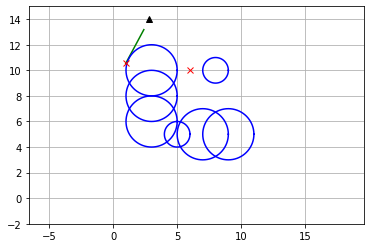

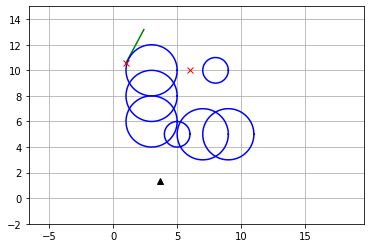

found path!!


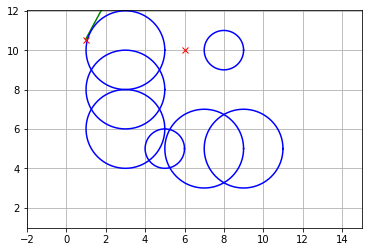

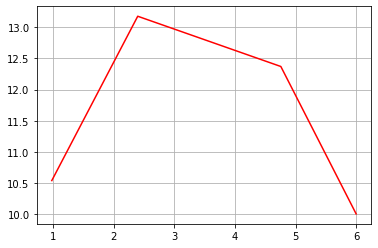

In [ ]:
import numpy as np 
import imageio

curr = [0, 0]
obstacleList = [(5, 5, 1), (3, 6, 2), (3, 8, 2), (3, 10, 2), (7, 5, 2),
                (9, 5, 2), (8, 10, 1)]  # [x, y, radius]


while (True):
    rrt = RRT_closest(
        start=curr,
        goal=[6, 10],
        rand_area=[-2, 15],
        obstacle_list=obstacleList,
        max_iter=20)
    path = rrt.planning(animation=True)

    if rrt.goal_reached():
        print("found path!!")
        break
    else:
        curr = [path[0][0], path[0][1]]
        del rrt

rrt.draw_graph()
plt.plot([x for (x, y) in path], [y for (x, y) in path], '-r')
plt.grid(True)
plt.pause(0.01)  # Need for Mac
plt.show()

FileNotFoundError: ignored

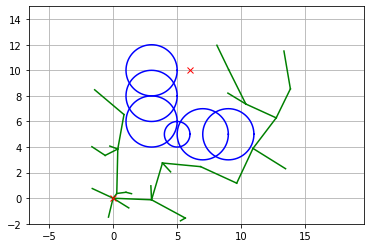

In [6]:
# Path smoothing

# ====Search Path with RRT====
# Parameter
obstacleList = [
    (5, 5, 1),
    (3, 6, 2),
    (3, 8, 2),
    (3, 10, 2),
    (7, 5, 2),
    (9, 5, 2)
] 
rrt = RRT(start=[0, 0], goal=[6, 10],
          rand_area=[-2, 15], obstacle_list=obstacleList)
path = rrt.planning(animation=False)

# Path smoothing
maxIter = 100000
smoothedPath = path_smoothing(path, maxIter, obstacleList)

# Draw final path
if show_animation:
    rrt.draw_graph()
    # plt.plot([x for (x, y) in path], [y for (x, y) in path], '-r')

    plt.plot([x for (x, y) in smoothedPath], [
        y for (x, y) in smoothedPath], '-c')

    plt.grid(True)
    plt.pause(0.01)  # Need for Mac
    plt.show()

Iter: 0 , number of nodes: 1
Iter: 1 , number of nodes: 2
Iter: 2 , number of nodes: 3
Iter: 3 , number of nodes: 4
Iter: 4 , number of nodes: 5
Iter: 5 , number of nodes: 6
Iter: 6 , number of nodes: 7
Iter: 7 , number of nodes: 8
Iter: 8 , number of nodes: 9
Iter: 9 , number of nodes: 9
Iter: 10 , number of nodes: 9
Iter: 11 , number of nodes: 9
Iter: 12 , number of nodes: 9
Iter: 13 , number of nodes: 9
Iter: 14 , number of nodes: 9
Iter: 15 , number of nodes: 10
Iter: 16 , number of nodes: 10
Iter: 17 , number of nodes: 11
Iter: 18 , number of nodes: 12
Iter: 19 , number of nodes: 13
Iter: 20 , number of nodes: 14
Iter: 21 , number of nodes: 15
Iter: 22 , number of nodes: 15
Iter: 23 , number of nodes: 16
Iter: 24 , number of nodes: 17
found path!!


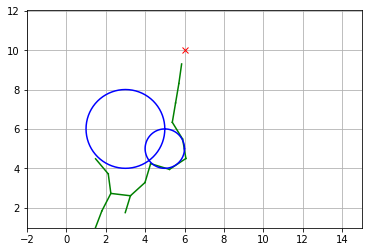

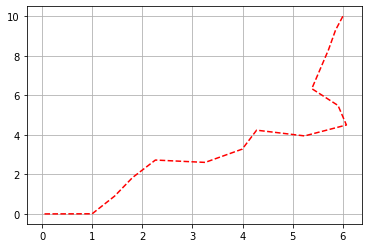

In [ ]:
# RRT*

# ====Search Path with RRT====
obstacle_list = [
    (5, 5, 1),
    (3, 6, 2),
    # (3, 8, 2),
    # (3, 10, 2),
    # (7, 5, 2),
    # (9, 5, 2),
    # (8, 10, 1),
    # (6, 12, 1),
]  # [x,y,size(radius)]

# Set Initial parameters
rrt_star = RRTStar(
    start=[0, 0],
    goal=[6, 10],
    max_iter=500,
    rand_area=[-2, 15],
    obstacle_list=obstacle_list,
    expand_dis=1)
path = rrt_star.planning(animation=False)

if path is None:
    print("Cannot find path")
else:
    print("found path!!")

    # Draw final path
    if show_animation:
        rrt_star.draw_graph()
        plt.plot([x for (x, y) in path], [y for (x, y) in path], 'r--')
        plt.grid(True)
plt.show()
